# Initial Setup

In [5]:
# --- Environment Setup ---
# Run this cell if you are using Google Colab or a fresh environment without dependencies installed.
# If you are running locally with the Conda environment set up (per README), you can skip this.

try:
    import qiskit
    import qiskit_finance
    print("✅ Libraries are already installed.")
except ImportError:
    print("⏳ Libraries not found. Installing now... (This may take a few minutes)")
    !pip install qiskit qiskit-finance qiskit-algorithms qiskit-aer qiskit-ibm-runtime matplotlib pylatexenc python-dotenv
    print("✅ Installation complete. Please restart the runtime/kernel if needed.")

✅ Libraries are already installed.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import LinearAmplitudeFunctionGate

from dotenv import load_dotenv
load_dotenv()

Matplotlib is building the font cache; this may take a moment.


# Classical Monte Carlo Simulation

In [3]:
import numpy as np

S = 2.0 # Spot Price
K = 1.896 # Strike Price
vol = 0.4 # Volatility (sigma)
r = 0.05 # Risk-free rate
T = 40 / 365 # Time to maturity (years)

def run_classical_monte_carlo(num_samples):
  Z = np.random.standard_normal(num_samples)
  S_T = S * np.exp((r - 0.5 * vol**2) * T + vol * np.sqrt(T) * Z)

  payoffs = np.maximum(0, S_T - K)

  # Average the payoffs and discount back to today
  # Price = exp(-rT) * Average(Payoffs)
  option_price = np.exp(-r * T) * np.mean(payoffs)

  return option_price

In [6]:
M_high_precision = 100000 # Number of simulations
classical_price = run_classical_monte_carlo(M_high_precision)

print(f"Classical Monte Carlo Price (M={M_high_precision}): ${classical_price:.4f}")

M_low_precision = 1000
quick_check_price = run_classical_monte_carlo(M_low_precision)

print(f"Quick Check Price (M={M_low_precision}): ${quick_check_price:.4f}")
print(f"Difference (Error): ${abs(classical_price - quick_check_price):.4f}")

Classical Monte Carlo Price (M=100000): $0.1703
Quick Check Price (M=1000): $0.1637
Difference (Error): $0.0066


# Approach 1: Building the Circuit Step-by-Step

In [ ]:
num_uncertainty_qubits = 3

S = 2.0
vol = 0.4
r = 0.05
T = 40 / 365

mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

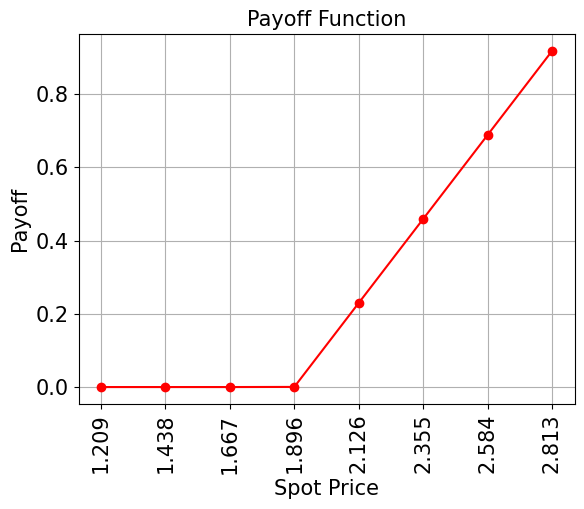

In [4]:
strike_price = 1.896

x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

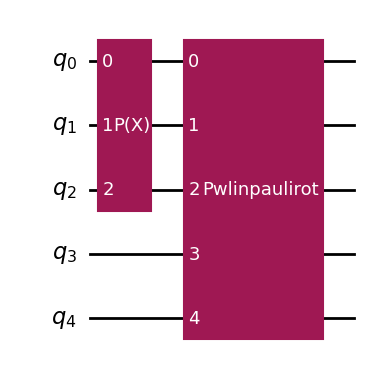

In [23]:
c_approx = 0.25

breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunctionGate(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

european_call.decompose().draw(output='mpl')

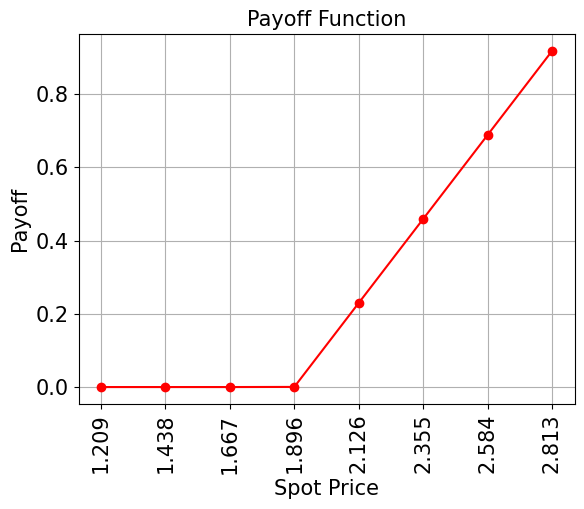

In [6]:
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [7]:
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.1623
exact delta value:   	0.8098


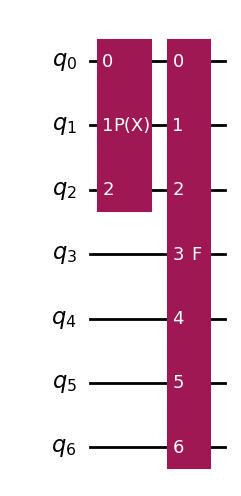

In [8]:
european_call.decompose().draw(output='mpl')

In [9]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)

ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=StatevectorSampler()
)

In [10]:
result = ae.estimate(problem)

In [11]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1696
Confidence interval:	[0.1622, 0.1770]


# Approach 2: Using Qiskit Finance Application Classes

In [12]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [13]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = european_call_pricing.to_estimation_problem()
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=StatevectorSampler()
)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1681
Confidence interval:	[0.1607, 0.1755]


In [14]:
from qiskit_finance.applications.estimation import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

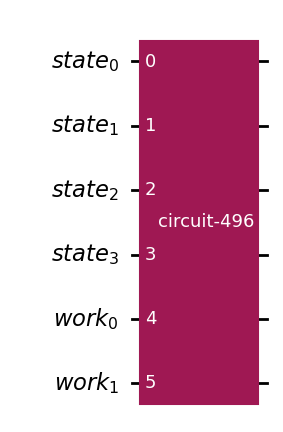

In [24]:
european_call_delta._objective.decompose().draw(output='mpl')

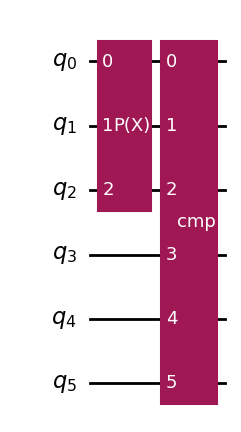

In [20]:
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(uncertainty_model, range(num_uncertainty_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)

european_call_delta_circ.decompose().draw(output='mpl')

In [17]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = european_call_delta.to_estimation_problem()

ae_delta = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=StatevectorSampler()
)

In [18]:
result_delta = ae_delta.estimate(problem)

In [19]:
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Estimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	0.8098
Estimated value: 	0.8091
Confidence interval: 	[0.8066, 0.8117]
